In [ ]:
!unzip data.zip

In [2]:
#@title 2. 필수 라이브러리 임포트
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model # (Sequential과 Model 둘 다 임포트)
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.applications import EfficientNetB0, VGG16 # (앙상블을 위해 2개 모델 임포트)
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
from glob import glob

# Scikit-learn (결과 평가용)
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.19.0


In [ ]:
#@title 3. [중요] 데이터 경로 및 하이퍼파라미터 설정

DATASET_PATH = "/content/flowers/" # <--- 이 경로를 수정하세요

# 모델 하이퍼파라미터
IMG_SIZE = (224, 224) # EfficientNet/VGG16 공통 입력 크기
BATCH_SIZE = 100
BUFFER_SIZE = tf.data.AUTOTUNE
VALIDATION_SPLIT = 0.2
SEED = 42
EPOCHS = 20 # (전이 학습은 비교적 적은 Epochs로도 수렴 가능)

Analyzing class distribution in directory...
Found 5 classes:
['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


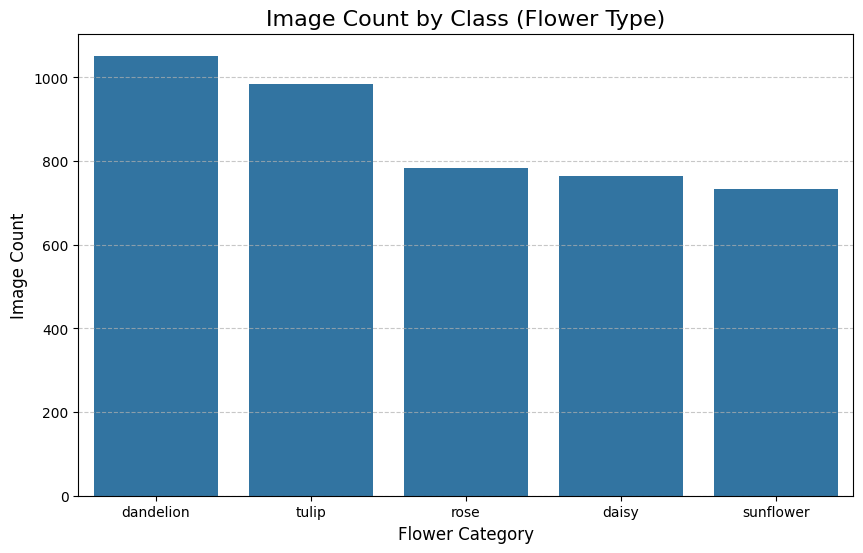

In [ ]:
#@title 4. [EDA 보강] 클래스 분포 확인 (Bar Plot - 영문)

print("Analyzing class distribution in directory...")
try:
    class_paths = glob(os.path.join(DATASET_PATH, '*'))
    class_names_eng = sorted([os.path.basename(p) for p in class_paths if os.path.isdir(p)])
    NUM_CLASSES = len(class_names_eng)

    if NUM_CLASSES == 0:
        raise FileNotFoundError("No class subdirectories found in DATASET_PATH.")

    print(f"Found {NUM_CLASSES} classes:")
    print(class_names_eng) # 예: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

    # 각 클래스별 이미지 개수 카운트
    class_counts = []
    for class_name in class_names_eng:
        count = len(os.listdir(os.path.join(DATASET_PATH, class_name)))
        class_counts.append(count)

    # 시각화를 위한 DataFrame 생성
    df_counts = pd.DataFrame({
        'ClassName': class_names_eng,
        'Count': class_counts
    }).sort_values(by='Count', ascending=False)

    # 클래스 분포 시각화
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_counts, x='ClassName', y='Count')
    plt.title('Image Count by Class (Flower Type)', fontsize=16)
    plt.xlabel('Flower Category', fontsize=12)
    plt.ylabel('Image Count', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

except Exception as e:
    print(f"Error checking directories: {e}")
    print(f"Please verify the DATASET_PATH: {DATASET_PATH}")

In [5]:
#@title 5. 데이터 로드 및 분리 (tf.data Pipeline)

# 1. 훈련 데이터셋 (Training Dataset) 로드 (전체의 80%)
try:
    train_ds = tf.keras.utils.image_dataset_from_directory(
        DATASET_PATH,
        validation_split=VALIDATION_SPLIT,
        subset="training",
        seed=SEED,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE
    )

    # 2. 검증 데이터셋 (Validation Dataset) 로드 (전체의 20%)
    val_ds = tf.keras.utils.image_dataset_from_directory(
        DATASET_PATH,
        validation_split=VALIDATION_SPLIT,
        subset="validation",
        seed=SEED,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE
    )

    class_names = train_ds.class_names # (Cell 4의 class_names_eng와 동일해야 함)
    print("\nTensorFlow Class Names (Loaded):")
    print(class_names)

except Exception as e:
    print(f"\nError loading dataset from directory: {e}")
    print("Ensure the DATASET_PATH is correct and contains sub-folders for each class.")

Found 4317 files belonging to 5 classes.
Using 3454 files for training.
Found 4317 files belonging to 5 classes.
Using 863 files for validation.

TensorFlow Class Names (Loaded):
['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']



Visualizing Sample Images with Augmentation...


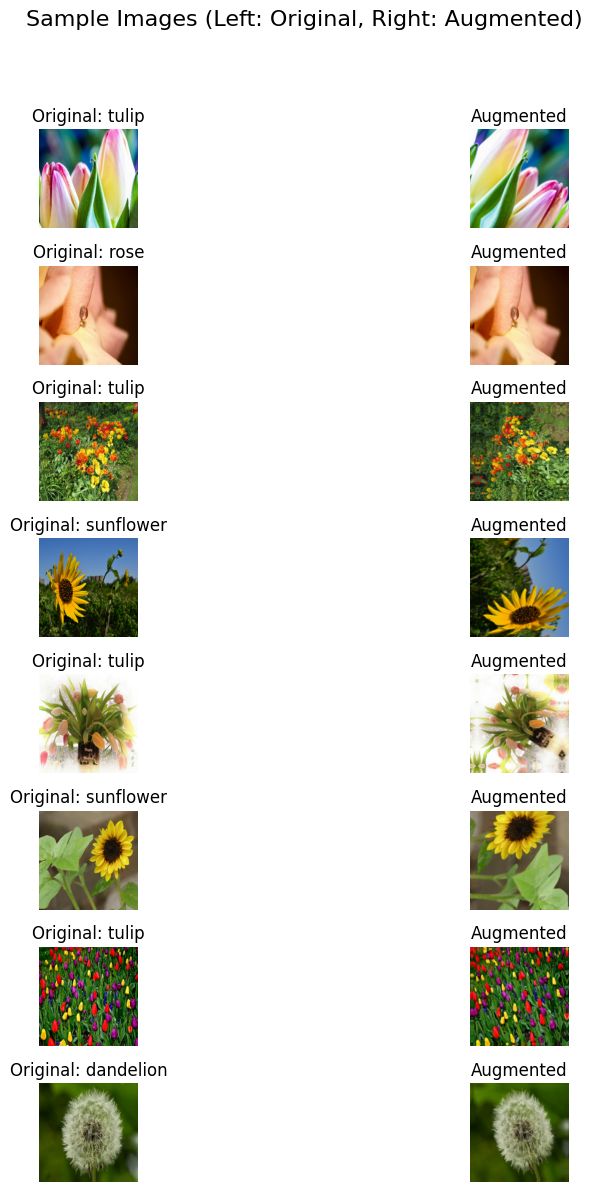

In [6]:
#@title 6. [EDA 보강] 샘플 이미지 및 증강(Augmentation) 시각화

# 1. 데이터 증강 레이어 정의
data_augmentation = Sequential([
    RandomFlip("horizontal", seed=SEED),
    RandomRotation(0.2, seed=SEED),
    RandomZoom(0.2, seed=SEED)
], name="data_augmentation")

# 2. 샘플 이미지 시각화 (증강 적용)
print("\nVisualizing Sample Images with Augmentation...")
plt.figure(figsize=(12, 12))
plt.suptitle('Sample Images (Left: Original, Right: Augmented)', fontsize=16, y=1.02)

# 훈련셋에서 8개 이미지를 가져와 비교
for images, labels in train_ds.take(1): # 1개 배치(32개)를 가져옴
    for i in range(8):
        # 원본 이미지
        ax1 = plt.subplot(8, 2, 2*i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Original: {class_names[labels[i]]}")
        plt.axis("off")

        # 증강된 이미지
        ax2 = plt.subplot(8, 2, 2*i + 2)
        augmented_image = data_augmentation(tf.expand_dims(images[i], 0))
        plt.imshow(augmented_image[0].numpy().astype("uint8"))
        plt.title(f"Augmented")
        plt.axis("off")
    break # 1개 배치만 사용

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

In [ ]:
#@title 7. 데이터 파이프라인 최적화 (Normalization)

# 데이터 증강 (훈련셋에만 적용)
train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=BUFFER_SIZE)

# 성능 최적화 (Caching & Prefetching)
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=BUFFER_SIZE)
val_ds = val_ds.cache().prefetch(buffer_size=BUFFER_SIZE)

print("\nData pipelines configured (Augmentation on train_ds only).")
print("Normalization will be applied inside each specific model.")


Data pipelines configured (Augmentation on train_ds only).
Normalization will be applied inside each specific model.


In [ ]:
#@title 8. [모델 1] EfficientNetB0 정의 및 학습

def build_effnet_model(num_classes):
    """EfficientNetB0 기반 전이학습 모델 정의"""
    # 1. 입력 레이어
    inputs = tf.keras.Input(shape=IMG_SIZE + (3,))

    # 2. 전처리 레이어 (EffNet용)
    x = tf.keras.applications.efficientnet.preprocess_input(inputs)

    # 3. 기본 모델 로드 (전처리 레이어를 input_tensor로 연결)
    base_model = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_tensor=x # (input_shape 대신 input_tensor 사용)
    )
    base_model.trainable = False # 가중치 동결

    # 4. 분류기 헤드(Head) 추가
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.4)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs) # (최종 모델 결합)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy', # (라벨이 정수형이므로 'sparse_' 사용)
        metrics=['accuracy']
    )
    return model

# EarlyStopping 콜백 정의
early_stopper = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

print("--- Training Model 1: EfficientNetB0 ---")
model_1_effnet = build_effnet_model(NUM_CLASSES)
# model_1_effnet.summary() # (모델 구조 확인용)

history_1 = model_1_effnet.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[early_stopper],
    verbose=1
)
print("\n--- Model 1 Training Finished ---")

--- Training Model 1: EfficientNetB0 ---
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.4138 - loss: 1.4061 - val_accuracy: 0.8320 - val_loss: 0.6439
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 54s 122ms/step - accuracy: 0.7723 - loss: 0.6897 - val_accuracy: 0.8610 - val_loss: 0.4638
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 0.8221 - loss: 0.5399 - val_accuracy: 0.8772 - val_loss: 0.3904
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 0.8368 - loss: 0.4882 - val_accuracy: 0.8864 - val_loss: 0.3522
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.8542 - loss: 0.4367 - val_accuracy: 0.8888 - val_loss: 0.3297
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.8694 - loss: 0.3865 - val_accuracy: 0.8888 - val_loss: 0.3159
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.8608 - loss: 0.3997 - val_accuracy: 0.8957 - val_loss: 0.3026
Epoch 8/10
3

In [9]:
#@title 9. [모델 2] VGG16 정의 및 학습

def build_vgg16_model(num_classes):
    """VGG16 기반 전이학습 모델 정의"""
    # 1. 입력 레이어
    inputs = tf.keras.Input(shape=IMG_SIZE + (3,))

    # 2. 전처리 레이어 (VGG16용: 0-255 스케일 -> BGR 변환 및 Zero-centering)
    x = tf.keras.applications.vgg16.preprocess_input(inputs) # VGG16 고유 전처리

    # 3. 기본 모델 로드 (가중치 동결)
    base_model = VGG16(
        include_top=False,
        weights='imagenet',
        input_tensor=x
    )
    base_model.trainable = False

    # 4. 분류기 헤드(Head) 추가
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation='relu')(x) # (VGG는 분류기 헤드가 조금 더 두꺼워도 좋음)
    x = Dropout(0.4)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), # (VGG는 낮은 LR 권장)
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [10]:
print("\n--- Training Model 2: VGG16 ---")
model_2_vgg16 = build_vgg16_model(NUM_CLASSES)
# model_2_vgg16.summary() # (모델 구조 확인용)

history_2 = model_2_vgg16.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[early_stopper], # (동일한 EarlyStopper 사용)
    verbose=1
)
print("\n--- Model 2 Training Finished ---")


--- Training Model 2: VGG16 ---
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.2167 - loss: 5.4280 - val_accuracy: 0.4276 - val_loss: 2.3091
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 616ms/step - accuracy: 0.4050 - loss: 2.8063 - val_accuracy: 0.5933 - val_loss: 1.4175
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 607ms/step - accuracy: 0.5190 - loss: 1.9435 - val_accuracy: 0.6698 - val_loss: 1.1470
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 22s 632ms/step - accuracy: 0.5843 - loss: 1.4801 - val_accuracy: 0.6906 - val_loss: 0.9928
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 605ms/step - accuracy: 0.6342 - loss: 1.2565 - val_accuracy: 0.7196 - val_loss: 0.9047
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 608ms/step - accuracy: 0.6792 - loss: 1.1441 - val_accuracy: 0.7393 - val_loss: 0.8313
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 608ms/step - accuracy: 0.6918 - loss: 1.0310 - val_accuracy: 0.7451 - val_loss: 0.7895
Epoch 8/10
35/3

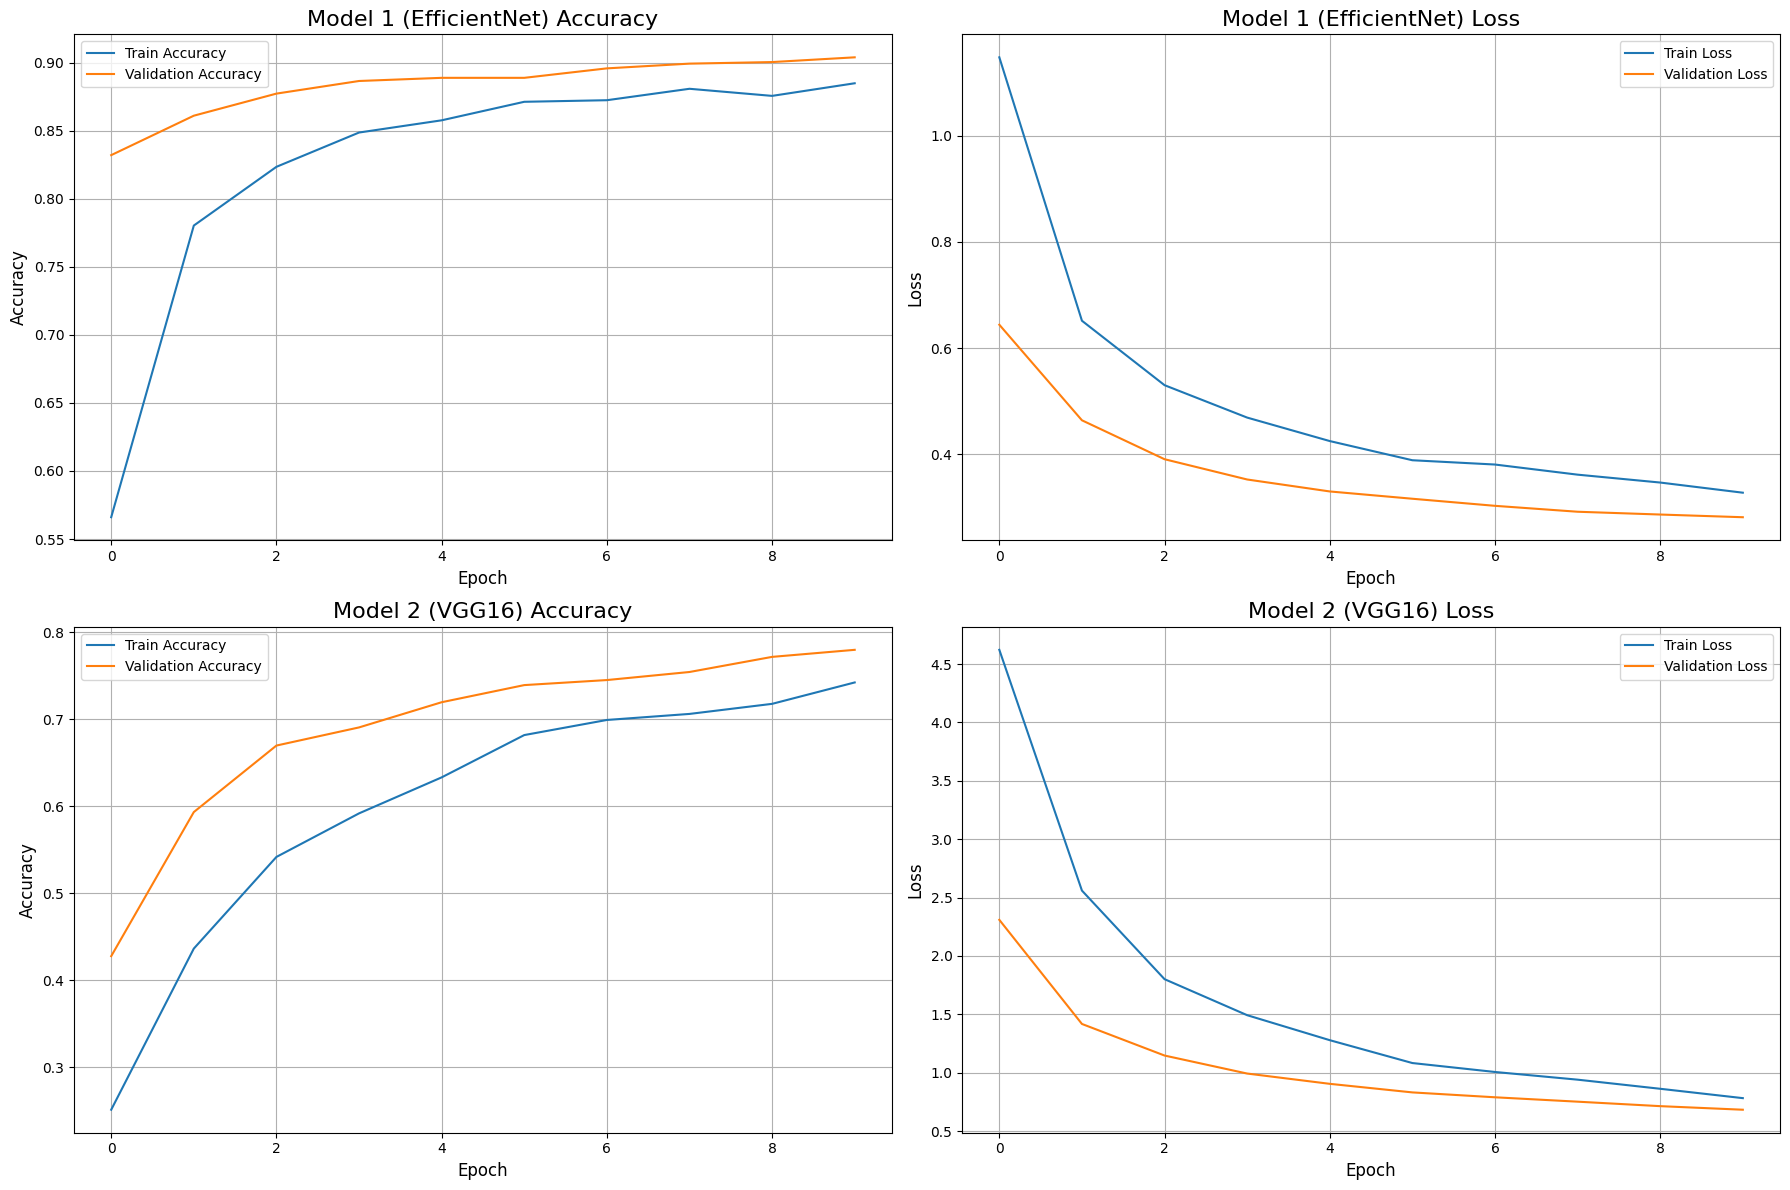

In [11]:
#@title 10. [결과 분석 보강] 개별 모델 학습 곡선 비교 (영문 Plot)

plt.figure(figsize=(18, 12))

# 모델 1 (EfficientNet) - Accuracy
plt.subplot(2, 2, 1)
plt.plot(history_1.history['accuracy'], label='Train Accuracy')
plt.plot(history_1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model 1 (EfficientNet) Accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True)

# 모델 1 (EfficientNet) - Loss
plt.subplot(2, 2, 2)
plt.plot(history_1.history['loss'], label='Train Loss')
plt.plot(history_1.history['val_loss'], label='Validation Loss')
plt.title('Model 1 (EfficientNet) Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)

# 모델 2 (VGG16) - Accuracy
plt.subplot(2, 2, 3)
plt.plot(history_2.history['accuracy'], label='Train Accuracy')
plt.plot(history_2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model 2 (VGG16) Accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True)

# 모델 2 (VGG16) - Loss
plt.subplot(2, 2, 4)
plt.plot(history_2.history['loss'], label='Train Loss')
plt.plot(history_2.history['val_loss'], label='Validation Loss')
plt.title('Model 2 (VGG16) Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [12]:
#@title 11. [결과 분석] 앙상블(Ensemble) 예측 및 최종 평가

print("Evaluating individual models and the ensemble...")

# 1. 검증 데이터셋에서 실제 라벨(y_true) 추출
# (val_ds를 순회하며 모든 y(라벨) 배치를 연결합니다)
y_true_labels = np.concatenate([y for x, y in val_ds], axis=0)

# 2. 각 모델의 예측 확률(Probabilities) 생성
print("Getting predictions from Model 1 (EffNet)...")
preds_model_1 = model_1_effnet.predict(val_ds)
print("Getting predictions from Model 2 (VGG16)...")
preds_model_2 = model_2_vgg16.predict(val_ds)

# 3. [앙상블] 예측 확률 평균 (Averaging Ensemble)
# (여기서는 50:50으로 평균. (예: 0.6 * preds_1 + 0.4 * preds_2 처럼 가중치 조절도 가능))
preds_ensemble = (preds_model_1 + preds_model_2) / 2.0

# 4. 각 예측의 최종 클래스(Labels) 도출
labels_model_1 = np.argmax(preds_model_1, axis=1)
labels_model_2 = np.argmax(preds_model_2, axis=1)
labels_ensemble = np.argmax(preds_ensemble, axis=1)

# 5. 각 모델의 정확도 출력
print("\n--- Final Accuracy Comparison ---")
print(f"Model 1 (EfficientNet) Accuracy: {accuracy_score(y_true_labels, labels_model_1) * 100:.2f}%")
print(f"Model 2 (VGG16) Accuracy:        {accuracy_score(y_true_labels, labels_model_2) * 100:.2f}%")
print(f"Ensemble (Average) Accuracy:   {accuracy_score(y_true_labels, labels_ensemble) * 100:.2f}%")

Evaluating individual models and the ensemble...
Getting predictions from Model 1 (EffNet)...
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 928ms/step
Getting predictions from Model 2 (VGG16)...
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 517ms/step

--- Final Accuracy Comparison ---
Model 1 (EfficientNet) Accuracy: 90.38%
Model 2 (VGG16) Accuracy:        77.98%
Ensemble (Average) Accuracy:   87.49%



--- Final Ensemble Model Evaluation Report ---

[Ensemble Classification Report (English)]
              precision    recall  f1-score   support

       daisy       0.92      0.84      0.88       144
   dandelion       0.91      0.88      0.90       206
        rose       0.84      0.79      0.81       137
   sunflower       0.91      0.92      0.92       172
       tulip       0.81      0.91      0.86       204

    accuracy                           0.87       863
   macro avg       0.88      0.87      0.87       863
weighted avg       0.88      0.87      0.87       863


Plotting Ensemble Confusion Matrix...


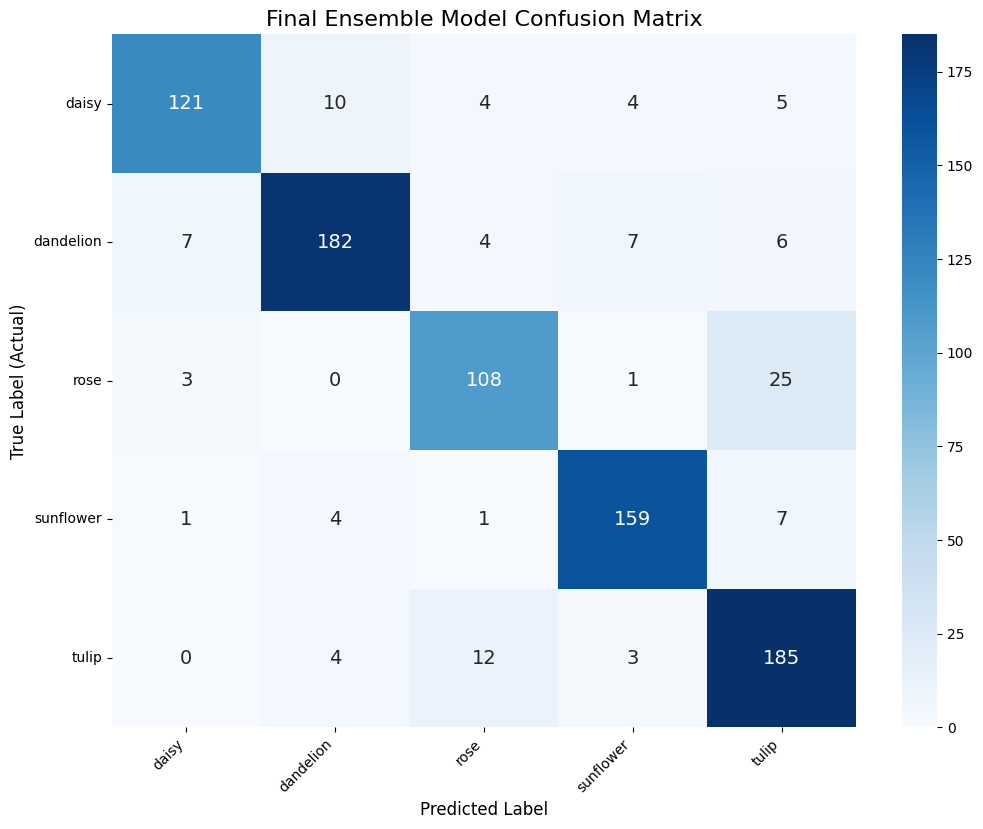

In [13]:
#@title 12. [결과 시각화 보강] 최종 앙상블 분류 리포트 및 혼동 행렬

print("\n--- Final Ensemble Model Evaluation Report ---")

# 1. 앙상블 분류 리포트 (Classification Report)
print("\n[Ensemble Classification Report (English)]")
print(classification_report(y_true_labels, labels_ensemble, target_names=class_names))

# 2. 앙상블 혼동 행렬 (Confusion Matrix) 시각화
print("\nPlotting Ensemble Confusion Matrix...")
cm = confusion_matrix(y_true_labels, labels_ensemble)

plt.figure(figsize=(12, 9))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            annot_kws={"size": 14})

plt.title('Final Ensemble Model Confusion Matrix', fontsize=16)
plt.ylabel('True Label (Actual)', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()